In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
from cpymad.madx import Madx
%matplotlib notebook

### Function to extracting a Matrix from MADX
https://gitlab.cern.ch/abt-optics-and-code-repository/simulation-codes/cpymad_examples/-/blob/master/MATRIX_extraction.ipynb

In [2]:
def get_matrix_from_twiss(twiss):
    elem = twiss.iloc[-1] # iloc[-1] takes last row of the data frame
    matExtracted = np.matrix([
        elem[['re11', 're12', 're13', 're14', 're15', 're16']].values.astype(float),
        elem[['re21', 're22', 're23', 're24', 're25', 're26']].values.astype(float),
        elem[['re31', 're32', 're33', 're34', 're35', 're36']].values.astype(float),
        elem[['re41', 're42', 're43', 're44', 're45', 're46']].values.astype(float),
        elem[['re51', 're52', 're53', 're54', 're55', 're56']].values.astype(float),
        elem[['re61', 're62', 're63', 're64', 're65', 're66']].values.astype(float),
    ])
    return matExtracted

### Test to run the whole get_initial_conditions_lhc_q20.madx file

In [3]:
## madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
## madx.option(verbose=False, debug=False, echo=True, warn=False, twiss_print=False) #Hides the output in the terminal
## madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls/ps_extraction/tt2tt10_lhc_q20/stitched/get_initial_conditions_lhc_q20.madx")
## madx.quit()

## The model D16STRAY and F16SHIM deflects the beam strongly back towards the inside of the ring  with quad K1 and sextupole K2 components.

#### They are placed as seen in: https://gitlab.cern.ch/acc-models/acc-models-tls/-/blob/2021/ps_extraction/tt2tt10_lhc_q20/stitched/get_initial_conditions_lhc_q20.madx

In [4]:
madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
madx.option(verbose=False, debug=False, echo=True, warn=False, twiss_print=False)

madx.beam(particle='proton', pc=26, exn=3.5e-6,eyn=3.5E-6)
madx.input('BRHO:= BEAM->PC * 3.3356;')

len_ft16 = 7.701173928

madx.command.sequence.clone('FT16', refer="entry", l=len_ft16)
madx.command.endsequence()

madx.command.rbend.clone('D16STRAY', L=2.20480, ANGLE=0.0, K1=-.047, K2=0.33)
madx.command.rbend.clone('F16SHIM', L=2.19624,ANGLE=0.021,K1=0.0)

madx.command.seqedit(sequence='FT16')
madx.command.install(element='D16STRAY_1', class_='D16STRAY', at='2.700072902') # Random positions, remeber starts from middle
madx.command.install(element='F16SHIM_1', class_='F16SHIM', at='4.904893572')
madx.command.endedit()

madx.use(sequence="FT16")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.07.22 15:41:27      +
  ++++++++++++++++++++++++++++++++++++++++++++


#### Initial conditions from MADX stitched model of PS extraction to TT10 LHC Q20 beam
https://gitlab.cern.ch/acc-models/acc-models-tls/-/blob/2021/ps_extraction/tt2tt10_lhc_q20/stitched/get_initial_conditions_lhc_q20.madx

In [5]:
betx0 = 2.5103613982e+01 ;
bety0 = 8.3789531557e+00 ;
alfx0 = -2.3322645191e+00 ;
alfy0 = 9.7954156718e-01 ;
dx0 = 3.0982680415e+00 ;
dy0 = 0.0000000000e+00 ;
dpx0 = 2.6262543044e-01 ;
dpy0 = 0.0000000000e+00 ;

#### Initial conditions from https://codimd.web.cern.ch/05LpRgDIRIKUpRnTWTfbEA

In [6]:
LHCx = 1.078422e-01
LHCxp = 3.131043e-02
TOFx = 1.173072e-01
TOFxp = 2.975372e-02
ADx = 1.101851e-01
ADxp = 2.973021e-02

# Choose beam type here
initialValues = [LHCx,LHCxp,0,0,0,0]

## Reference RXX Matrix coefficient calculation

- I'm varying one parameter at a time (x, xp, y, yp, T, PT) with the other coordinates set to zero such as:

\begin{equation}
\left(\begin{array}{c}
{\pmb{x^{New}}}  \\
{x'^{New}}  \\
{y^{New}}  \\
{y'^{New}}  \\
{t^{New}}  \\
{(\frac{\delta p}{p})^{New}}  \\
\end{array}\right) =
\left(\begin{array}{cccccc}
R_{11} & R_{12} & R_{13} & R_{14} & R_{15} & R_{16} \\
R_{21} & R_{22} & R_{23} & R_{24} & R_{25} & R_{26} \\
R_{31} & R_{32} & R_{33} & R_{34} & R_{35} & R_{36} \\
R_{41}  & R_{42} & R_{43} & R_{44} & R_{45} & R_{46} \\
R_{51} & R_{52} & R_{53} & R_{54} & R_{55} & R_{56} \\
R_{61} & R_{62} & R_{63} & R_{64} & R_{65} & R_{66} \\
\end{array}\right)
\left(\begin{array}{c}
{\pmb{x^{Old}}}  \\
{0}  \\
{0}  \\
{0}  \\
{0}  \\
{0}  \\
\end{array}\right)
\end{equation}


 with $x^{Old}$ = [-0.01  -0.005  0.     0.005  0.01 ] for example
- Plotting $x^{New}$ as a function of $x^{Old}$
- then $x^{New}$ as a function of $x'^{Old}$
- ...
- $(\frac{\delta p}{p})^{New}$ as a function of $(\frac{\delta p}{p})^{Old}$

#### Settings for the computation

In [7]:
var_names = ("x", "xp", "y", "yp", "T", "PT")
var_units = ("[m]", "[rad]", "[m]", "[rad]", "[m]", "[ ]")
values_lim = 0.1 # calculate the coefficient in the range +/-values_lim
values_no = 10      # choose how many points you want to calculate

### Varying the x and px component as input 

#### Remark: turning off the sextupole component K2 of basically removes all fringe fields effect 

#### Linear regression: The value $R^2=1$ corresponds to sum of squared residuals (SSR) $\sum_{i}(y{i}-f(x_{i}))^2=0$ and corresponds to a perfect fit.

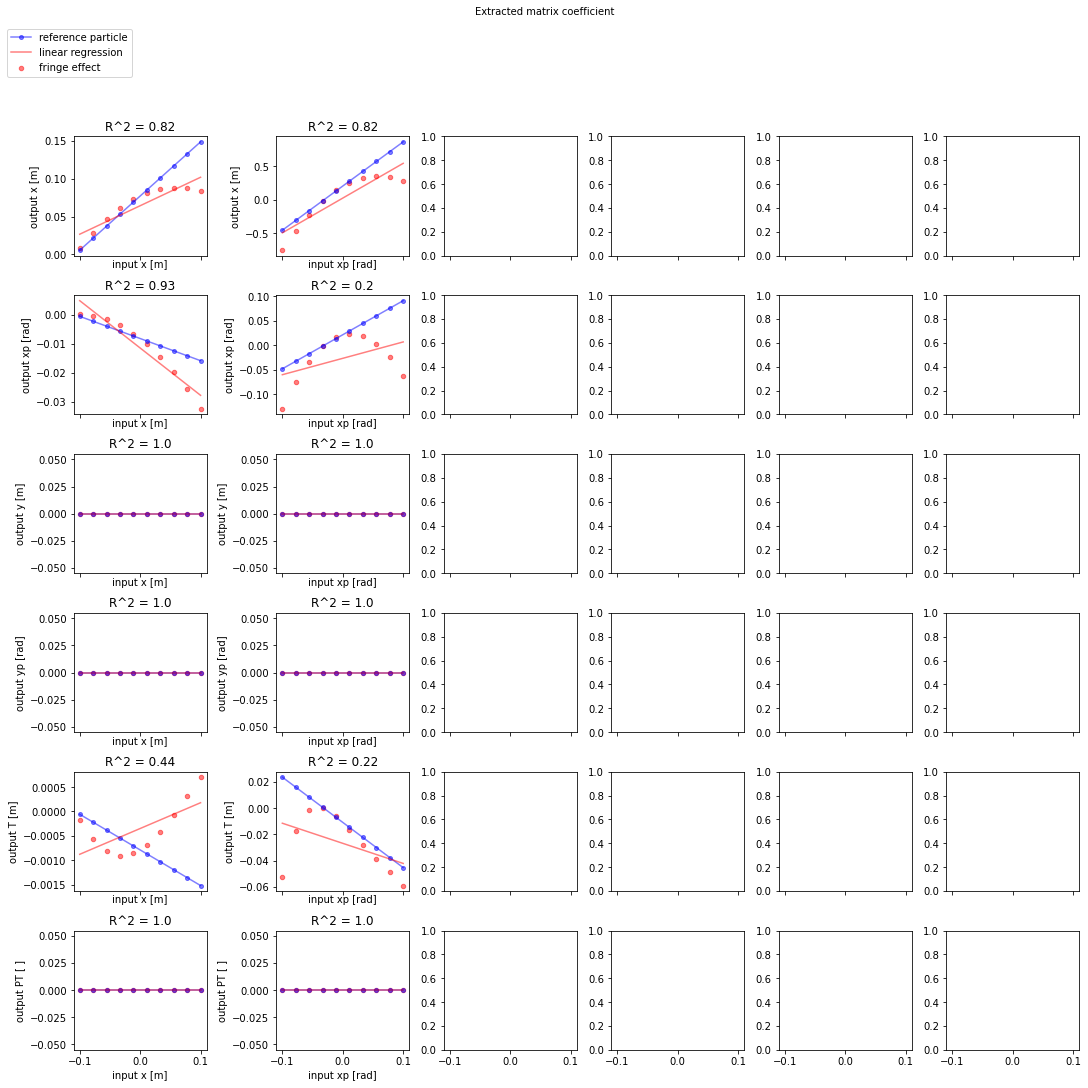

In [16]:
fig, ax = plt.subplots(6, 6, figsize=(15,15), constrained_layout=True, sharex=True, squeeze=False)
#squeeze argument if I only have one sublot instead of 6x6 filled

xvalues = np.linspace(-values_lim, values_lim, values_no)# This centers the linspace around the position of the beam
yvalues = np.zeros(values_no)

# Reference Matrix
twiss = madx.twiss(betx=betx0, bety=bety0,
                   alfx=alfx0, alfy=alfy0,
                   x=initialValues[0],px=initialValues[1],
                   dx=dx0, dy=dy0,
                   dpx=dpx0, dpy=dpy0,
                   rmatrix=True).dframe()
matExtractedRef = get_matrix_from_twiss(twiss)

for k in range (2):
    vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])
    vectorNew = np.array([0.,0.,0.,0.,0.,0.])
    for j in range (6):
        for i in range (0,values_no):
            vectorOld[k]=xvalues[i]+initialValues[k]
            vectorNew = np.dot(matExtractedRef,vectorOld) # Matrix multiplication 
            yvalues[i]=vectorNew[j]
        ax[j,k].plot(xvalues, yvalues, marker = 'o', markersize=4, color = 'b', alpha=0.5, label="reference particle")

        yvalues = np.zeros(values_no)
        for i in range (0,values_no): # Change the twiss inputs around the reference particle
            vectorOld[k]=xvalues[i]+initialValues[k]

            if k==0:
                twiss = madx.twiss(betx=betx0, bety=bety0, # We reevaluate the twiss and transport matrix
                                   alfx=alfx0, alfy=alfy0,
                                   x=xvalues[i]+initialValues[0], px=initialValues[1],
                                   dx=dx0, dy=dy0,
                                   dpx=dpx0, dpy=dpy0,
                                   rmatrix=True).dframe()
            if k==1:
                twiss = madx.twiss(betx=betx0, bety=bety0,
                                   alfx=alfx0, alfy=alfy0,
                                   x=initialValues[0], px=xvalues[i]+initialValues[1],
                                   dx=dx0, dy=dy0,
                                   dpx=dpx0, dpy=dpy0,
                                   rmatrix=True).dframe()            
            
            matExtracted = get_matrix_from_twiss(twiss)

            vectorNew = np.dot(matExtracted,vectorOld) # Matrix multiplication    
            yvalues[i]=vectorNew[j]
        ax[j,k].scatter(xvalues, yvalues, marker = 'o', s=20, color = 'r', alpha=0.5, label="fringe effect")
        ax[j,k].set_xlabel("input "+var_names[k]+" "+var_units[k])
        ax[j,k].set_ylabel("output "+var_names[j]+" "+var_units[j])
        
        #Linear regression
        xlin = xvalues.reshape((-1,1))
        model = LinearRegression().fit(xlin,yvalues)
        r_sq = model.score(xlin, yvalues)
        y_pred = model.predict(xlin)
        ax[j,k].plot(xvalues, y_pred, color = 'r', alpha=0.5, label="linear regression")
        ax[j,k].title.set_text('R^2 = '+str(round(r_sq, 2)))

fig.suptitle("Extracted matrix coefficient", fontsize=10)
ax[0,0].legend(loc=(-0.5, 1.5),fontsize=10)
fig.show()